In [3]:
import sqlite3 as sql

import numpy as np
import pandas as pd
from pandas import cut, read_sql
import pickle as pkl
from random import choices
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.optimize as optimize

In [4]:
indir_osc_weight_MC = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/event_selections/osc_weights.csv"
osc_weight_MC = pd.read_csv(indir_osc_weight_MC).sort_values('old_event_no').reset_index(drop = True)
osc_weight_MC.rename(columns = {'old_event_no':'event_no'}, inplace = True)
print(len(osc_weight_MC))

68471353


In [5]:
indir_track_cascade_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/track_mu_Burnsample_RD_Full_db.csv"
indir_energy_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/energy_Burnsample_RD_Full_db.csv"
indir_zenith_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/zenith_Burnsample_RD_Full_db.csv"
indir_azimuth_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/azimuth_Burnsample_RD_Full_db.csv"
indir_multiclass_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/pid_Burnsample_RD_Full_db.csv"

indir_track_cascade_MC = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/trained_models/osc_next_level3_v2/dynedge_track_mu_Track_cascade_MP_data_SplitInIcePulses_on_equal_track_cascade_neutrinos_test/results.csv"
indir_energy_MC = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/trained_models/osc_next_level3_v2/Peter_Morten_energy_1_mill_even_track_cascade_attempt_2_test_set/results.csv"
indir_zenith_MC = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/trained_models/osc_next_level3_v2/MP_data_zenith_1_mill_even_track_cascade_attempt2_test_set/results.csv"
indir_azimuth_MC = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/trained_models/osc_next_level3_v2/MP_data_azimuth_test_1_mill_attempt2_test_set_equal_track_cascade/results.csv"
indir_multiclass_MC = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/trained_models/osc_next_level3_v2/dynedge_pid_classification3_test/results.csv"



In [6]:
track_cascade_RD = pd.read_csv(indir_track_cascade_RD).sort_values('event_no').reset_index(drop = True)
energy_RD = pd.read_csv(indir_energy_RD).sort_values('event_no').reset_index(drop = True)
zenith_RD = pd.read_csv(indir_zenith_RD).sort_values('event_no').reset_index(drop = True)
azimuth_RD = pd.read_csv(indir_azimuth_RD).sort_values('event_no').reset_index(drop = True)
multiclass_RD = pd.read_csv(indir_multiclass_RD).sort_values('event_no').reset_index(drop = True)

track_cascade_MC = pd.read_csv(indir_track_cascade_MC).sort_values('event_no').reset_index(drop = True)
energy_MC = pd.read_csv(indir_energy_MC).sort_values('event_no').reset_index(drop = True)
zenith_MC = pd.read_csv(indir_zenith_MC).sort_values('event_no').reset_index(drop = True)
azimuth_MC = pd.read_csv(indir_azimuth_MC).sort_values('event_no').reset_index(drop = True)
multiclass_MC = pd.read_csv(indir_multiclass_MC).sort_values('event_no').reset_index(drop = True)

In [7]:
print(np.shape(energy_MC))

(4585522, 4)


In [8]:
track_cascade_MC = pd.merge(track_cascade_MC,osc_weight_MC,on='event_no',how='inner').reset_index(drop=True)
energy_MC = pd.merge(energy_MC,osc_weight_MC,on='event_no',how='inner').reset_index(drop=True)
zenith_MC = pd.merge(zenith_MC,osc_weight_MC,on='event_no',how='inner').reset_index(drop=True)
azimuth_MC = pd.merge(azimuth_MC,osc_weight_MC,on='event_no',how='inner').reset_index(drop=True)
multiclass_MC = pd.merge(multiclass_MC,osc_weight_MC,on='event_no',how='inner').reset_index(drop=True)

In [9]:
nr_electron_neutrino_i3_files = 645
nr_muon_neutrino_i3_files = 1550
nr_tau_neutrino_i3_files = 350
nr_electron_neutrinos_total = 8.3*10**6
nr_muon_neutrinos_total = 20.11*10**6
nr_tau_neutrinos_total = 8.89*10**6
nr_electron_neutrinos_test = 2.53*10**6
nr_muon_neutrinos_test = 2.53*10**6
nr_tau_neutrinos_test = 2.53*10**6

electron_neutrino_add_weight = 1/(nr_electron_neutrino_i3_files*nr_electron_neutrinos_test/nr_electron_neutrinos_total)
muon_neutrino_add_weight = 1/(nr_muon_neutrino_i3_files*nr_muon_neutrinos_test/nr_muon_neutrinos_total)
tau_neutrino_add_weight = 1/(nr_tau_neutrino_i3_files*nr_tau_neutrinos_test/nr_tau_neutrinos_total)

print(electron_neutrino_add_weight,muon_neutrino_add_weight,tau_neutrino_add_weight)

electron_neutrino_event_nos = multiclass_MC['event_no'][multiclass_MC['pid'].isin((-12,12))]
muon_neutrino_event_nos = multiclass_MC['event_no'][multiclass_MC['pid'].isin((-14,14))]
tau_neutrino_event_nos = multiclass_MC['event_no'][multiclass_MC['pid'].isin((-16,16))]
print(multiclass_MC['osc_weight'][multiclass_MC['event_no'].isin((electron_neutrino_event_nos))].head(10))
multiclass_MC['osc_weight'][multiclass_MC['event_no'].isin((electron_neutrino_event_nos))] *= electron_neutrino_add_weight
print(multiclass_MC['osc_weight'][multiclass_MC['event_no'].isin((electron_neutrino_event_nos))].head(10))
multiclass_MC['osc_weight'][multiclass_MC['event_no'].isin((muon_neutrino_event_nos))] *= muon_neutrino_add_weight
multiclass_MC['osc_weight'][multiclass_MC['event_no'].isin((tau_neutrino_event_nos))] *= tau_neutrino_add_weight

0.005086251800104177 0.0051281397424454925 0.010039525691699604
60576    1.840449e-07
60580    2.090857e-07
60581    2.488525e-07
60584    1.464047e-07
60585    4.468664e-07
60586    1.545411e-07
60589    1.566633e-07
60593    1.790866e-07
60594    1.240840e-07
60597    1.770583e-07
Name: osc_weight, dtype: float64


/tmp/ipykernel_22767/679252950.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multiclass_MC['osc_weight'][multiclass_MC['event_no'].isin((electron_neutrino_event_nos))] *= electron_neutrino_add_weight


60576    9.360985e-10
60580    1.063463e-09
60581    1.265727e-09
60584    7.446510e-10
60585    2.272875e-09
60586    7.860352e-10
60589    7.968292e-10
60593    9.108796e-10
60594    6.311227e-10
60597    9.005632e-10
Name: osc_weight, dtype: float64


/tmp/ipykernel_22767/679252950.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multiclass_MC['osc_weight'][multiclass_MC['event_no'].isin((muon_neutrino_event_nos))] *= muon_neutrino_add_weight
/tmp/ipykernel_22767/679252950.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multiclass_MC['osc_weight'][multiclass_MC['event_no'].isin((tau_neutrino_event_nos))] *= tau_neutrino_add_weight


In [10]:
Burnsample_weight = 1/(365.2425*24*3600*10*0.01)
track_cascade_RD['osc_weight'] = np.ones(len(track_cascade_RD))*Burnsample_weight
energy_RD['osc_weight'] = np.ones(len(energy_RD))*Burnsample_weight 
zenith_RD['osc_weight'] = np.ones(len(zenith_RD))*Burnsample_weight 
azimuth_RD['osc_weight'] = np.ones(len(azimuth_RD))*Burnsample_weight 
multiclass_RD['osc_weight'] = np.ones(len(multiclass_RD))*Burnsample_weight 


In [11]:
print(osc_weight_MC['osc_weight'][osc_weight_MC['event_no']==320.0])
print(np.shape(track_cascade_MC))
print(track_cascade_MC.head(10))




320    6.029706e-07
Name: osc_weight, dtype: float64
(4585522, 5)
   Unnamed: 0  track_mu_pred  track_mu  event_no    osc_weight
0     4109962       0.511379       1.0     320.0  6.029706e-07
1     1810779       0.437622       1.0     344.0  3.311957e-07
2     3806952       0.412146       1.0     370.0  8.609741e-08
3     3266424       0.461440       1.0     378.0  8.196414e-08
4     1569369       0.516302       1.0     381.0  2.664120e-07
5      634826       0.552189       1.0     456.0  4.187771e-07
6     3590453       0.492596       1.0     582.0  7.628354e-07
7      917985       0.457702       1.0     613.0  5.899805e-08
8     2817052       0.450149       1.0     619.0  3.381217e-07
9     1738854       0.433827       1.0     643.0  1.902381e-07


In [12]:
print(multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))])

167         3.092118e-09
177         1.698418e-09
186         4.415195e-10
192         4.203236e-10
193         1.366198e-09
                ...     
22779353    1.188132e-18
22779354    1.582778e-13
22779355    6.228240e-15
22779356    2.805869e-17
22779357    1.809434e-13
Name: osc_weight, Length: 7592311, dtype: float64


[0.07847413 0.07743676 0.07678738 0.07276646 0.07176283 0.06827034
 0.07147134 0.06520273 0.0697739  0.06410418]
[0.05530668 0.05344341 0.05317723 0.05058935 0.05014571 0.04804583
 0.04859298 0.04522135 0.04736559 0.0461382 ]


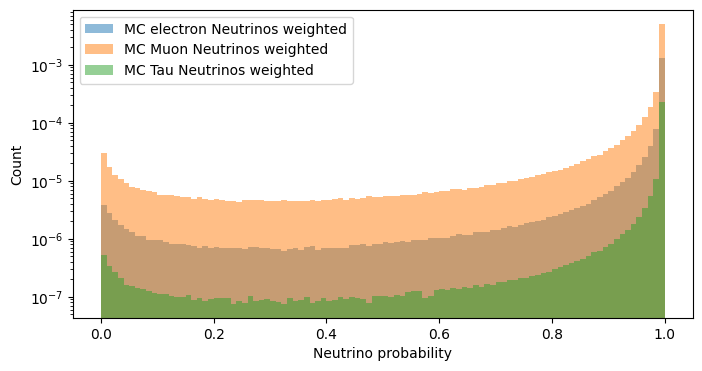

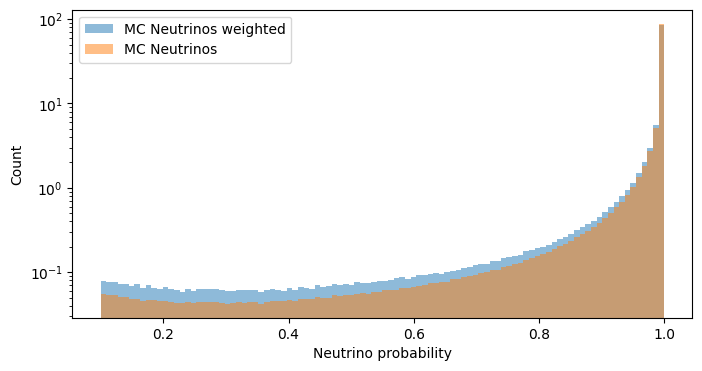

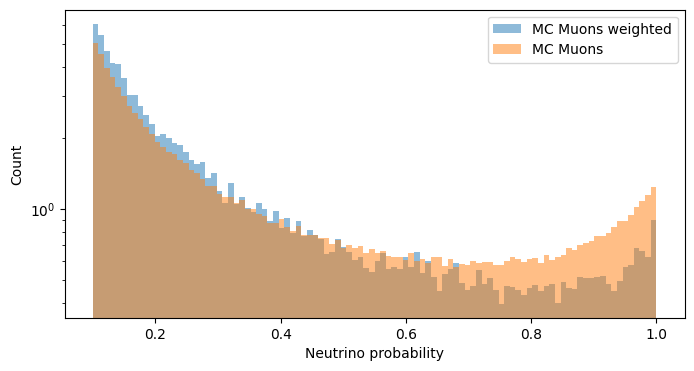

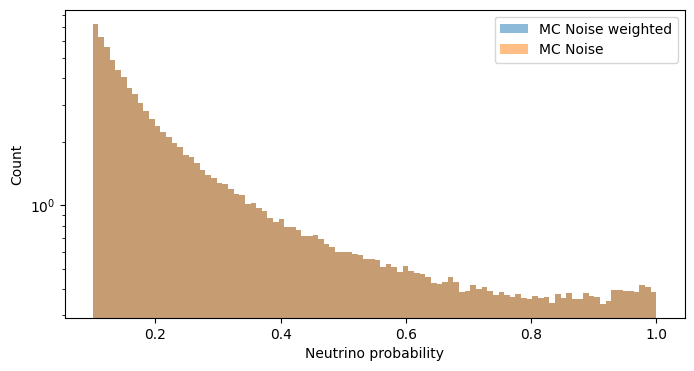

In [13]:
bins_to_use = np.linspace(0,1,101)
bins_to_fit = np.linspace(0.1,1,101)

fig,axs =  plt.subplots(figsize=(8, 4))
counts_test_weights, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-12,12))],bins=bins_to_use,density=False,alpha=0.5,label='MC electron Neutrinos weighted',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-12,12))])
counts_test_weights, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-14,14))],bins=bins_to_use,density=False,alpha=0.5,label='MC Muon Neutrinos weighted',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-14,14))])
counts_test_weights, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-16,16))],bins=bins_to_use,density=False,alpha=0.5,label='MC Tau Neutrinos weighted',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-16,16))])

axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Neutrino probability')
axs.legend()



bins_to_use = np.linspace(0,1,101)
bins_to_fit = np.linspace(0.1,1,101)

fig,axs =  plt.subplots(figsize=(8, 4))
counts_test_weights, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))],bins=bins_to_fit,density=True,alpha=0.5,label='MC Neutrinos weighted',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))])
counts_test, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))],bins=bins_to_fit,density=True,alpha=0.5,label='MC Neutrinos')
axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Neutrino probability')
axs.legend()
print(counts_test_weights[:10])
print(counts_test[:10])

fig,axs =  plt.subplots(figsize=(8, 4))
counts_muon_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-13,13))],bins=bins_to_fit,density=True,alpha=0.5,label='MC Muons weighted',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-13,13))])
counts_muon_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-13,13))],bins=bins_to_fit,density=True,alpha=0.5,label='MC Muons')
axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Neutrino probability')
axs.legend()

fig,axs =  plt.subplots(figsize=(8, 4))
counts_noise_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-1,1))],bins=bins_to_fit,density=True,alpha=0.5,label='MC Noise weighted',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-1,1))])
counts_noise_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-1,1))],bins=bins_to_fit,density=True,alpha=0.5,label='MC Noise')
axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Neutrino probability')
axs.legend()

[ 0.          0.01123535 10.38644543]
True


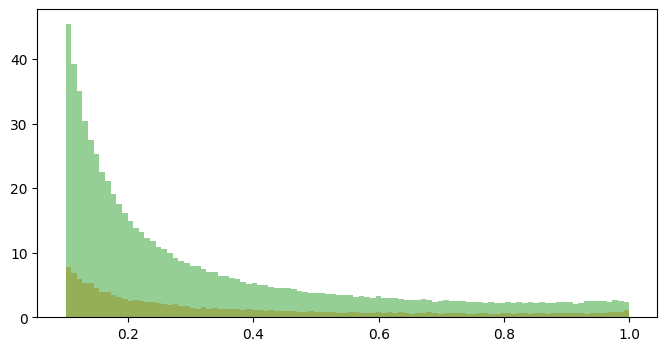

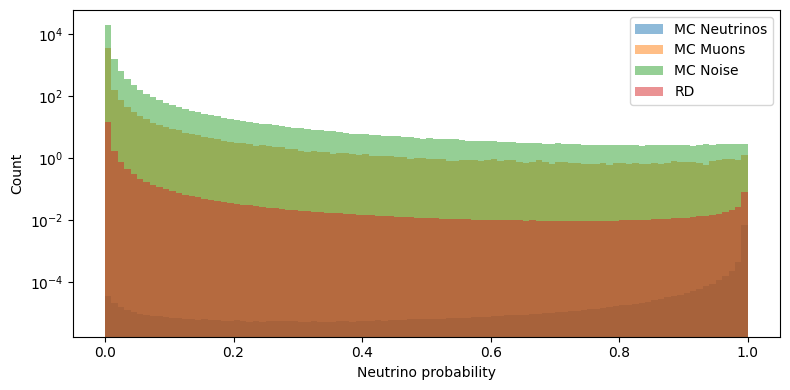

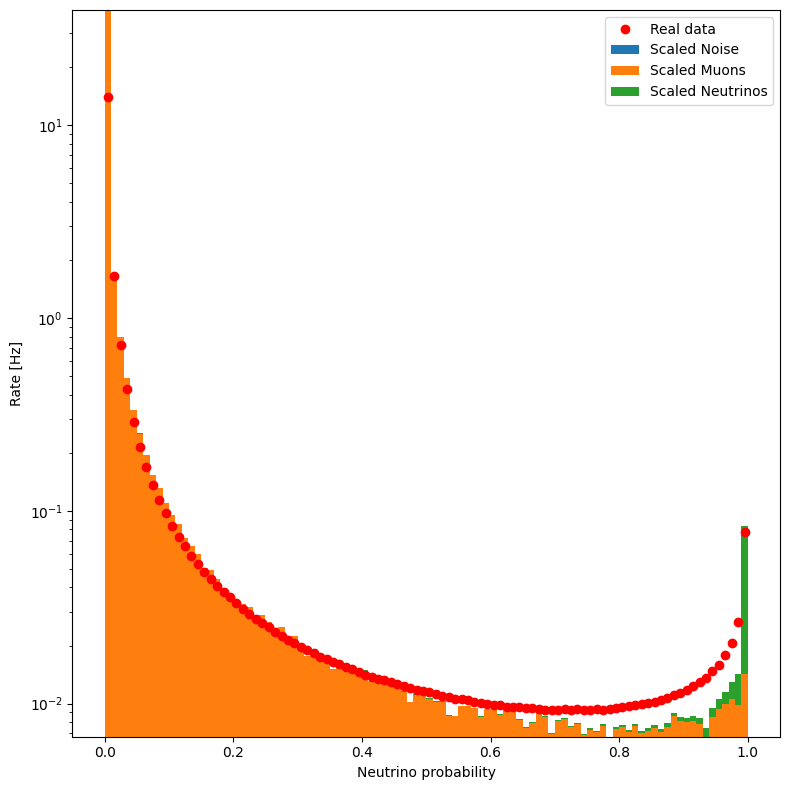

In [14]:
bins_to_use = np.linspace(0,1,101)
bins_to_fit = np.linspace(0.1,1,101)

fig,axs =  plt.subplots(figsize=(8, 4))
counts_neutrino_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))],bins=bins_to_fit,density=False,alpha=0.5,label='MC Neutrinos',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))])
counts_muon_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-13,13))],bins=bins_to_fit,density=False,alpha=0.5,label='MC Muons',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-13,13))])
counts_noise_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-1,1))],bins=bins_to_fit,density=False,alpha=0.5,label='MC Noise',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-1,1))])
counts_RD_fit, _,_ = axs.hist(multiclass_RD['pid_neutrino_pred'],bins=bins_to_fit,density=False,alpha=0.5,label='RD',weights=multiclass_RD['osc_weight'])


fig, axs = plt.subplots(figsize=(8, 4))


bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2

counts_neutrino, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))],bins=bins_to_use,density=False,alpha=0.5,label='MC Neutrinos',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))])
counts_muon, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-13,13))],bins=bins_to_use,density=False,alpha=0.5,label='MC Muons',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-13,13))])
counts_noise, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-1,1))],bins=bins_to_use,density=False,alpha=0.5,label='MC Noise',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-1,1))])
counts_RD, _,_ = axs.hist(multiclass_RD['pid_neutrino_pred'],bins=bins_to_use,density=False,alpha=0.5,label='RD',weights=multiclass_RD['osc_weight'])


axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Neutrino probability')
axs.legend()

fig.tight_layout()


def chi_square(N_scalers):
    sum = 0
    for i in range(len(bins_to_fit)-1):
        sum+= (counts_RD_fit[i] - N_scalers[0]*counts_noise_fit[i] - N_scalers[1]*counts_muon_fit[i] - N_scalers[2]*counts_neutrino_fit[i])**2/counts_RD_fit[i]
    return sum

N_0 = [50000,50000,50000]
res = optimize.minimize(chi_square,N_0,bounds = ((0, None),(0, None), (0, None)))
print(res.x)
print(res.success)

counts_noise_plot = counts_noise*res.x[0]#
counts_muon_plot = counts_muon*res.x[1]##
counts_neutrino_plot = counts_neutrino*res.x[2]#*#


bin_width = bins_to_use[1]-bins_to_use[0]

fig, axs = plt.subplots(figsize=(8, 8))


axs.bar(bins_middle,counts_noise_plot,width=bin_width,label='Scaled Noise')
axs.bar(bins_middle,counts_muon_plot,width=bin_width,bottom=counts_noise_plot,label='Scaled Muons')
axs.bar(bins_middle,counts_neutrino_plot,width=bin_width,bottom=counts_noise_plot+counts_muon_plot,label='Scaled Neutrinos')


axs.plot(bins_middle,counts_RD,'o',label='Real data',color='red')
axs.set_xlabel('Neutrino probability')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('Rate [Hz]')
axs.set_yscale('log')
axs.legend(loc='upper right')

fig.tight_layout()

In [15]:
def to_logit(p):
    eps = 0.0000001
    try:
        if np.isnan(p):
            return
        p = p*(1-2*eps)+eps
        logit = np.log(p/(1-p))
    except ZeroDivisionError as e:
        print(e)
    return logit

safe_load_place_MC = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/event_selections/Neutrino_prob_logit_MC.csv"
load_logit_MC = True
if load_logit_MC:
    input = pd.read_csv(safe_load_place_MC)
    multiclass_MC['pid_neutrino_pred_logit'] = input['pid_neutrino_pred_logit']
else:
    multiclass_MC['pid_neutrino_pred_logit'] = pd.Series(multiclass_MC['pid_neutrino_pred']).apply(to_logit)
    multiclass_MC['pid_neutrino_pred_logit'].to_csv(safe_load_place_MC)




safe_load_place_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/event_selections/Neutrino_prob_logit_RD.csv"
load_logit_RD = True
if load_logit_RD:
    input = pd.read_csv(safe_load_place_RD)
    multiclass_RD['pid_neutrino_pred_logit'] = input['pid_neutrino_pred']
else:
    multiclass_RD['pid_neutrino_pred_logit'] = pd.Series(multiclass_RD['pid_neutrino_pred']).apply(to_logit)



In [16]:
# troels_clean_neutrino_selection_MC = multiclass_MC['event_no'][multiclass_MC['pid_neutrino_pred_logit']>2]
# troels_clean_neutrino_selection_RD = multiclass_RD['event_no'][multiclass_RD['pid_neutrino_pred_logit']>2]

# troels_clean_neutrino_cascade_selection_MC = track_cascade_MC['event_no'][(track_cascade_MC['track_mu_pred'] < 0.75) & (track_cascade_MC['event_no'].isin(troels_clean_neutrino_selection_MC))]
# troels_clean_neutrino_cascade_selection_RD = track_cascade_RD['event_no'][(track_cascade_RD['track_mu_pred'] < 0.75) & (track_cascade_RD['event_no'].isin(troels_clean_neutrino_selection_RD))]

# print(len(troels_clean_neutrino_cascade_selection_MC))
# print(len(troels_clean_neutrino_cascade_selection_RD))
# print(troels_clean_neutrino_cascade_selection_MC.head(2))
# print(troels_clean_neutrino_cascade_selection_RD.head(2))

# troels_clean_neutrino_cascade_selection_MC = pd.DataFrame(troels_clean_neutrino_cascade_selection_MC)
# troels_clean_neutrino_cascade_selection_MC = pd.merge(troels_clean_neutrino_cascade_selection_MC.reset_index(drop=True),track_cascade_MC.reset_index(drop=True),on='event_no',how='inner').reset_index(drop=True)
# troels_clean_neutrino_cascade_selection_MC = pd.merge(troels_clean_neutrino_cascade_selection_MC.reset_index(drop=True),multiclass_MC.reset_index(drop=True),on='event_no',how='inner').reset_index(drop=True)
# troels_clean_neutrino_cascade_selection_MC = pd.merge(troels_clean_neutrino_cascade_selection_MC.reset_index(drop=True),energy_MC.reset_index(drop=True),on='event_no',how='inner').reset_index(drop=True)
# troels_clean_neutrino_cascade_selection_MC = pd.merge(troels_clean_neutrino_cascade_selection_MC.reset_index(drop=True),azimuth_MC.reset_index(drop=True),on='event_no',how='inner').reset_index(drop=True)
# troels_clean_neutrino_cascade_selection_MC = pd.merge(troels_clean_neutrino_cascade_selection_MC.reset_index(drop=True),zenith_MC.reset_index(drop=True),on='event_no',how='inner').reset_index(drop=True)

# troels_clean_neutrino_cascade_selection_RD = pd.DataFrame(troels_clean_neutrino_cascade_selection_RD)
# troels_clean_neutrino_cascade_selection_RD = pd.merge(troels_clean_neutrino_cascade_selection_RD.reset_index(drop=True),track_cascade_RD.reset_index(drop=True),on='event_no',how='inner').reset_index(drop=True)
# troels_clean_neutrino_cascade_selection_RD = pd.merge(troels_clean_neutrino_cascade_selection_RD.reset_index(drop=True),multiclass_RD.reset_index(drop=True),on='event_no',how='inner').reset_index(drop=True)
# troels_clean_neutrino_cascade_selection_RD = pd.merge(troels_clean_neutrino_cascade_selection_RD.reset_index(drop=True),energy_RD.reset_index(drop=True),on='event_no',how='inner').reset_index(drop=True)
# troels_clean_neutrino_cascade_selection_RD = pd.merge(troels_clean_neutrino_cascade_selection_RD.reset_index(drop=True),azimuth_RD.reset_index(drop=True),on='event_no',how='inner').reset_index(drop=True)
# troels_clean_neutrino_cascade_selection_RD = pd.merge(troels_clean_neutrino_cascade_selection_RD.reset_index(drop=True),zenith_RD.reset_index(drop=True),on='event_no',how='inner').reset_index(drop=True)

# print(troels_clean_neutrino_cascade_selection_MC)

In [17]:


# #print(troels_clean_neutrino_cascade_selection_MC.columns)
# troels_clean_neutrino_cascade_selection_MC_final = troels_clean_neutrino_cascade_selection_MC.drop(['Unnamed: 0_x', 'osc_weight_x','Unnamed: 0_y',
#        'Unnamed: 0_x',
#         'osc_weight_x', 'Unnamed: 0_y',
#        'energy_y', 'osc_weight_y',
#        'Unnamed: 0', 'energy',
#        'osc_weight'], axis=1)
# troels_clean_neutrino_cascade_selection_MC_final.rename(columns = {'energy_x':'energy'}, inplace = True)
# print(troels_clean_neutrino_cascade_selection_MC_final.tail(4))


# print(azimuth_MC[azimuth_MC['event_no']==68471292])
# print(multiclass_MC[multiclass_MC['event_no']==68471292])
# #print(troels_clean_neutrino_cascade_selection_RD.columns)
# # print(troels_clean_neutrino_cascade_selection_RD.drop(['Unnamed: 0_x', 'osc_weight_x','Unnamed: 0_y',
# #        'pid',  'pid_neutrino_pred_logit', 'Unnamed: 0_x',
# #         'osc_weight_x', 'Unnamed: 0_y',
# #        'energy_y', 'osc_weight_y',
# #        'Unnamed: 0', 'energy',
# #        'osc_weight'], axis=1))

In [18]:
# print(troels_clean_neutrino_cascade_selection_RD.columns)
# troels_clean_neutrino_cascade_selection_RD_final = troels_clean_neutrino_cascade_selection_RD.drop([ 'Unnamed: 0_x', 'osc_weight_x',
#        'Unnamed: 0_y','pid'
#        , 'osc_weight_y', 'Unnamed: 0_x', 'osc_weight_x', 'Unnamed: 0_y', 'osc_weight_y', 'Unnamed: 0','osc_weight'], axis=1)
# print(troels_clean_neutrino_cascade_selection_RD_final.head(3))
# print(azimuth_RD[azimuth_RD['event_no']==7])
# print(multiclass_RD[multiclass_RD['event_no']==7])

In [19]:
# Troels_save_place = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/Troels_cascade_events/"
# troels_clean_neutrino_cascade_selection_MC_final.to_csv(Troels_save_place+'clean_cascade_events_MC.csv')
# troels_clean_neutrino_cascade_selection_RD_final.to_csv(Troels_save_place+'clean_cascade_events_RD.csv')

[8.24103232e-04 2.31625526e-03 8.25317046e+00]
True


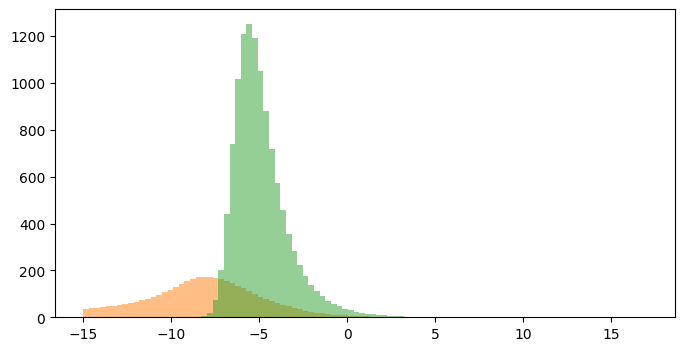

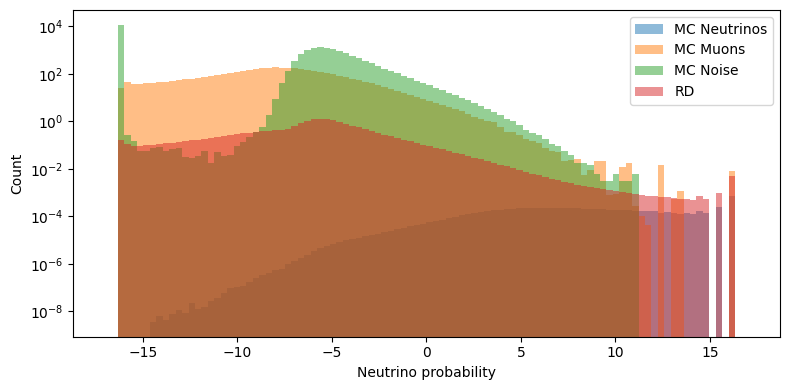

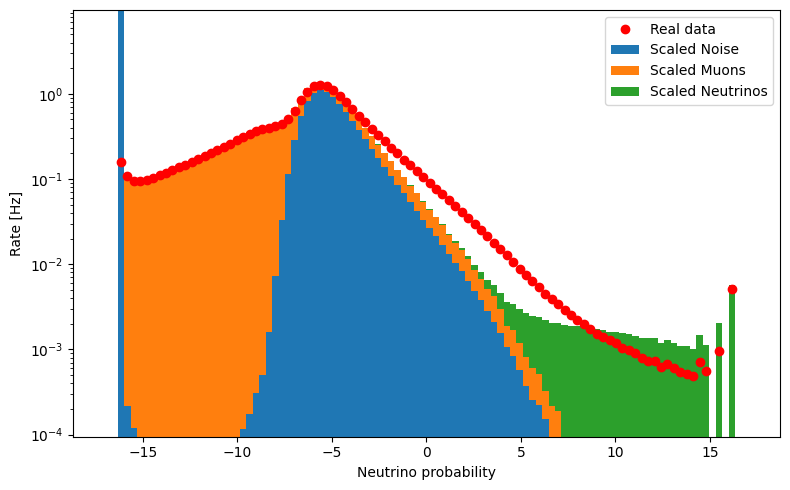

In [20]:
bins_to_use = np.linspace(-17,17,101)
bins_to_fit = np.linspace(-15,17,101)

fig,axs =  plt.subplots(figsize=(8, 4))
counts_neutrino_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred_logit'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))],bins=bins_to_fit,density=False,alpha=0.5,label='MC Neutrinos',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))])
counts_muon_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred_logit'][multiclass_MC['pid'].isin((-13,13))],bins=bins_to_fit,density=False,alpha=0.5,label='MC Muons',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-13,13))])
counts_noise_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred_logit'][multiclass_MC['pid'].isin((-1,1))],bins=bins_to_fit,density=False,alpha=0.5,label='MC Noise',weights = multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-1,1))])
counts_RD_fit, _,_ = axs.hist(multiclass_RD['pid_neutrino_pred_logit'],bins=bins_to_fit,density=False,alpha=0.5,label='RD',weights=multiclass_RD['osc_weight'])


fig, axs = plt.subplots(figsize=(8, 4))


bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2

counts_neutrino, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred_logit'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))],bins=bins_to_use,density=False,alpha=0.5,label='MC Neutrinos',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))])
counts_muon, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred_logit'][multiclass_MC['pid'].isin((-13,13))],bins=bins_to_use,density=False,alpha=0.5,label='MC Muons',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-13,13))])
counts_noise, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred_logit'][multiclass_MC['pid'].isin((-1,1))],bins=bins_to_use,density=False,alpha=0.5,label='MC Noise',weights=multiclass_MC['osc_weight'][multiclass_MC['pid'].isin((-1,1))])
counts_RD, _,_ = axs.hist(multiclass_RD['pid_neutrino_pred_logit'],bins=bins_to_use,density=False,alpha=0.5,label='RD',weights = multiclass_RD['osc_weight'])

axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Neutrino probability')
axs.legend()

fig.tight_layout()


def chi_square(N_scalers):
    sum = 0
    for i in range(len(bins_to_fit)-1):
        if counts_RD_fit[i] != 0:
            sum+= (counts_RD_fit[i] - N_scalers[0]*counts_noise_fit[i] - N_scalers[1]*counts_muon_fit[i] - N_scalers[2]*counts_neutrino_fit[i])**2/counts_RD_fit[i]
    return sum

N_0 = [ 1.69090118, 17.63873833,  0.03073277]
res = optimize.minimize(chi_square,N_0,bounds = ((0, None),(0, None), (0, None)))
print(res.x)
print(res.success)

counts_noise_plot = counts_noise*res.x[0]#
counts_muon_plot = counts_muon*res.x[1]##
counts_neutrino_plot = counts_neutrino*res.x[2]#*#



bin_width = bins_to_use[1]-bins_to_use[0]

fig, axs = plt.subplots(figsize=(8, 5))


axs.bar(bins_middle,counts_noise_plot,width=bin_width,label='Scaled Noise')
axs.bar(bins_middle,counts_muon_plot,width=bin_width,bottom=counts_noise_plot,label='Scaled Muons')
axs.bar(bins_middle,counts_neutrino_plot,width=bin_width,bottom=counts_noise_plot+counts_muon_plot,label='Scaled Neutrinos')


axs.plot(bins_middle,counts_RD,'o',label='Real data',color='red')
axs.set_xlabel('Neutrino probability')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('Rate [Hz]')
axs.set_yscale('log')
axs.legend(loc='upper right')

fig.tight_layout()

In [46]:
Neutrino_cut = 16
pure_neutrino_selection_RD = multiclass_RD['event_no'][multiclass_RD['pid_neutrino_pred_logit'] > Neutrino_cut]
pure_neutrino_selection_MC = multiclass_MC['event_no'][multiclass_MC['pid_neutrino_pred_logit'] > Neutrino_cut]

In [47]:
print('this many pure neutrinos RD',len(pure_neutrino_selection_RD))
print('this many pure neutrinos MC',len(pure_neutrino_selection_MC))
track_event_no = track_cascade_MC['event_no'][track_cascade_MC['track_mu']==1]
cascade_event_no = track_cascade_MC['event_no'][track_cascade_MC['track_mu']==0]

pure_neutrino_track_selection = track_event_no[track_event_no.isin((pure_neutrino_selection_MC))].reset_index(drop=True)

pure_neutrino_cascade_selection = cascade_event_no[cascade_event_no.isin((pure_neutrino_selection_MC))].reset_index(drop=True)
#print(track_event_no)
#print(cascade_event_no)

this many pure neutrinos RD 16145
this many pure neutrinos MC 773681


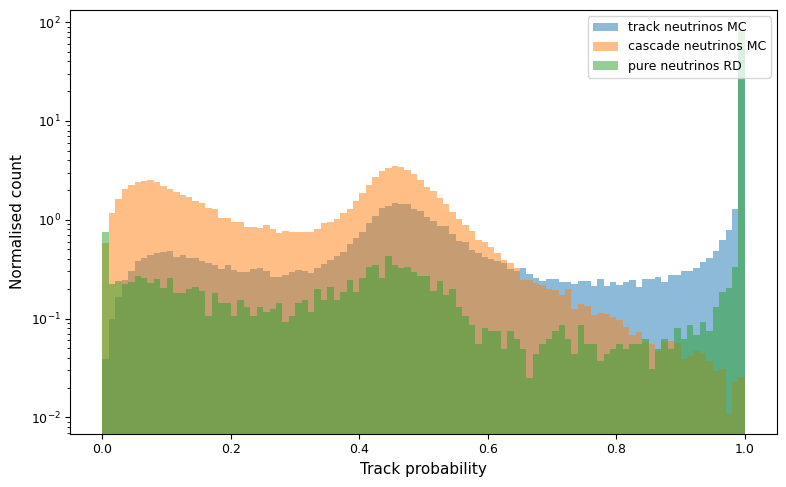

In [48]:
fig, axs = plt.subplots(figsize=(8, 5))

bins_to_use = np.linspace(0,1,101)
axs.hist(track_cascade_MC['track_mu_pred'][track_cascade_MC['event_no'].isin(pure_neutrino_track_selection)],density=True,bins=bins_to_use,label='track neutrinos MC',alpha=0.5,weights=track_cascade_MC['osc_weight'][track_cascade_MC['event_no'].isin(pure_neutrino_track_selection)])
axs.hist(track_cascade_MC['track_mu_pred'][track_cascade_MC['event_no'].isin(pure_neutrino_cascade_selection) ],density=True,bins=bins_to_use,label='cascade neutrinos MC',alpha=0.5,weights=track_cascade_MC['osc_weight'][track_cascade_MC['event_no'].isin(pure_neutrino_cascade_selection) ])
axs.hist(track_cascade_RD['track_mu_pred'][track_cascade_RD['event_no'].isin(pure_neutrino_selection_RD)],density=True,bins=bins_to_use,label='pure neutrinos RD',alpha=0.5,weights=track_cascade_RD['osc_weight'][track_cascade_RD['event_no'].isin(pure_neutrino_selection_RD)])

axs.set_xlabel('Track probability')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('Normalised count')
axs.set_yscale('log')
axs.legend(loc='upper right')

fig.tight_layout()

[0.00791441 0.01490132]
True


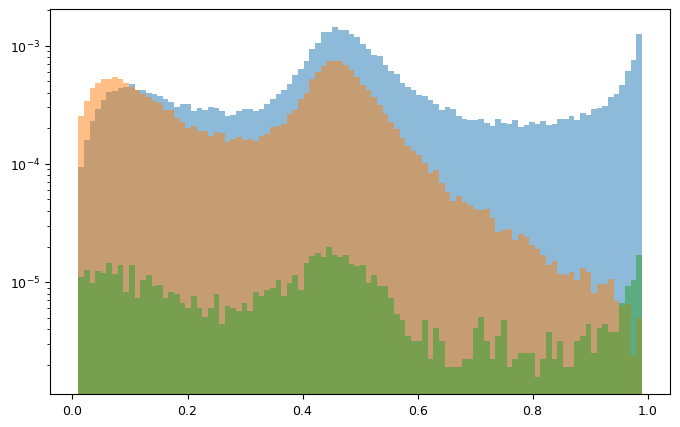

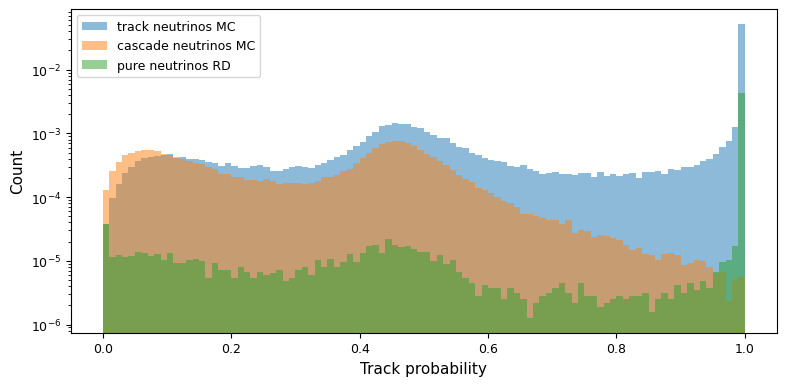

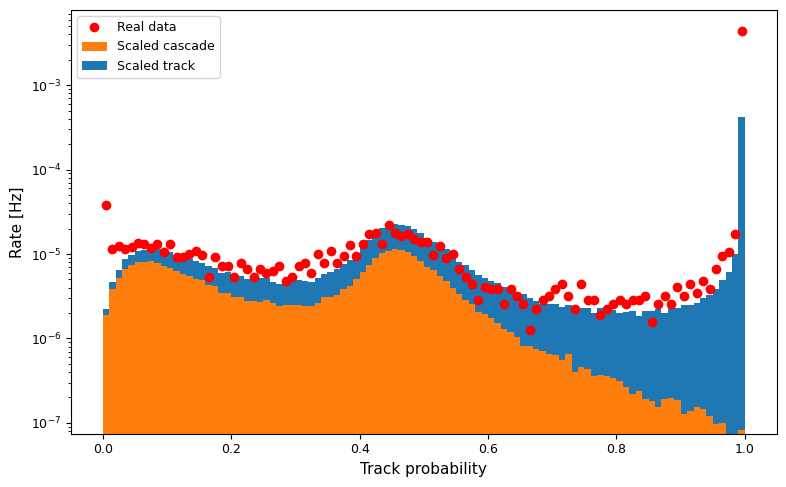

In [49]:
bins_to_use = np.linspace(0,1,101)
bins_to_fit = np.linspace(0.01,0.99,101)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2

fig, axs = plt.subplots(figsize=(8, 5))

counts_track_fit, _,_ = axs.hist(track_cascade_MC['track_mu_pred'][track_cascade_MC['event_no'].isin(pure_neutrino_track_selection)],density=False,bins=bins_to_fit,label='track neutrinos MC',alpha=0.5,weights=track_cascade_MC['osc_weight'][track_cascade_MC['event_no'].isin(pure_neutrino_track_selection)])
counts_cascade_fit, _,_ = axs.hist(track_cascade_MC['track_mu_pred'][track_cascade_MC['event_no'].isin(pure_neutrino_cascade_selection)],density=False,bins=bins_to_fit,label='cascade neutrinos MC',alpha=0.5,weights = track_cascade_MC['osc_weight'][track_cascade_MC['event_no'].isin(pure_neutrino_cascade_selection)])
counts_RD_fit, _,_ = axs.hist(track_cascade_RD['track_mu_pred'][track_cascade_RD['event_no'].isin(pure_neutrino_selection_RD)],density=False,bins=bins_to_fit,label='pure neutrinos RD',alpha=0.5,weights=track_cascade_RD['osc_weight'][track_cascade_RD['event_no'].isin(pure_neutrino_selection_RD)])

axs.set_yscale('log')

fig, axs = plt.subplots(figsize=(8, 4))


counts_track, _,_ = axs.hist(track_cascade_MC['track_mu_pred'][track_cascade_MC['event_no'].isin(pure_neutrino_track_selection)],density=False,bins=bins_to_use,label='track neutrinos MC',alpha=0.5,weights=track_cascade_MC['osc_weight'][track_cascade_MC['event_no'].isin(pure_neutrino_track_selection)])
counts_cascade, _,_ = axs.hist(track_cascade_MC['track_mu_pred'][track_cascade_MC['event_no'].isin(pure_neutrino_cascade_selection)],density=False,bins=bins_to_use,label='cascade neutrinos MC',alpha=0.5,weights=track_cascade_MC['osc_weight'][track_cascade_MC['event_no'].isin(pure_neutrino_cascade_selection)])
counts_RD_multiclass, _,_ = axs.hist(track_cascade_RD['track_mu_pred'][track_cascade_RD['event_no'].isin(pure_neutrino_selection_RD)],density=False,bins=bins_to_use,label='pure neutrinos RD',alpha=0.5,weights=track_cascade_RD['osc_weight'][track_cascade_RD['event_no'].isin(pure_neutrino_selection_RD)])


axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Track probability')
axs.legend()

fig.tight_layout()


def chi_square(N_scalers):
    sum = 0
    for i in range(len(bins_to_fit)-1):
        sum+= (counts_RD_fit[i] - N_scalers[0]*counts_track_fit[i] - N_scalers[1]*counts_cascade_fit[i])**2/counts_RD_fit[i]
    return sum

N_0 = [50,50]
res = optimize.minimize(chi_square,N_0,bounds = ((0, None), (0, None)))
print(res.x)
print(res.success)

counts_track_plot = counts_track*res.x[0]#
counts_cascade_plot = counts_cascade*res.x[1]##

bin_width = bins_to_use[1]-bins_to_use[0]

fig, axs = plt.subplots(figsize=(8, 5))


axs.bar(bins_middle,counts_cascade_plot,width=bin_width,label='Scaled cascade',color='C1')
axs.bar(bins_middle,counts_track_plot,width=bin_width,bottom=counts_cascade_plot,label='Scaled track',color='C0')


axs.plot(bins_middle,counts_RD_multiclass,'o',label='Real data',color='red')
axs.set_xlabel('Track probability')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('Rate [Hz]')
axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()


In [50]:
track_cut = 0.9
cascade_cut = 0.75
pure_track_event_no_MC = track_cascade_MC['event_no'][(track_cascade_MC['track_mu_pred']>track_cut)]# & (track_cascade_MC['track_mu_pred'] < track_cut_2) ]
pure_track_event_no_RD = track_cascade_RD['event_no'][(track_cascade_RD['track_mu_pred']>track_cut)]# & (track_cascade_RD['track_mu_pred'] < track_cut_2)]


pure_cascade_event_no_MC = track_cascade_MC['event_no'][track_cascade_MC['track_mu_pred']<cascade_cut]
pure_cascade_event_no_RD = track_cascade_RD['event_no'][track_cascade_RD['track_mu_pred']<cascade_cut]


pure_track_selection_MC = pure_track_event_no_MC[pure_track_event_no_MC.isin(pure_neutrino_selection_MC)]
pure_track_selection_RD = pure_track_event_no_RD[pure_track_event_no_RD.isin(pure_neutrino_selection_RD)]


pure_cascade_selection_MC = pure_cascade_event_no_MC[pure_cascade_event_no_MC.isin(pure_neutrino_selection_MC)]
pure_cascade_selection_RD = pure_cascade_event_no_RD[pure_cascade_event_no_RD.isin(pure_neutrino_selection_RD)]

print(len(pure_track_selection_MC))
print(len(pure_track_selection_RD))
print(len(pure_cascade_selection_MC))
print(len(pure_cascade_selection_RD))

126776
13871
310442
2146


In [51]:
# print(len(pure_track_selection_MC))
# print(len(pure_track_selection_RD))

# fig, axs = plt.subplots(figsize=(8, 8))

# axs.hist(track_cascade_MC['track_mu_pred'][track_cascade_MC['event_no'].isin(pure_track_selection_MC)])
# axs.hist(track_cascade_RD['track_mu_pred'][track_cascade_RD['event_no'].isin(pure_track_selection_RD)])

# axs.set_xlabel('Neutrino probability')
# #axs.set_ylim(bottom=1000)
# axs.set_ylabel('Count')
# axs.set_yscale('log')
# axs.legend(loc='upper left')

# fig.tight_layout()

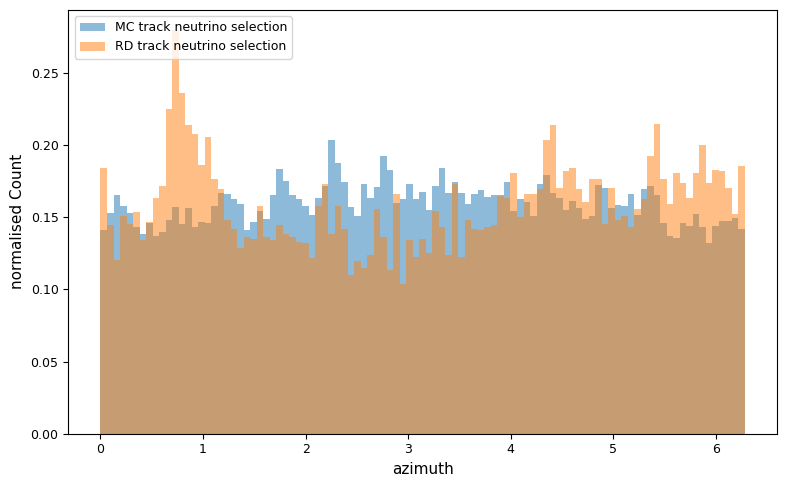

In [52]:
bins=np.linspace(0,np.pi*2,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(azimuth_MC['azimuth_pred'][azimuth_MC['event_no'].isin(pure_track_selection_MC)],density=True,label='MC track neutrino selection',bins=bins,alpha=0.5,weights=azimuth_MC['osc_weight'][azimuth_MC['event_no'].isin(pure_track_selection_MC)])
axs.hist(azimuth_RD['azimuth_pred'][azimuth_RD['event_no'].isin(pure_track_selection_RD)],density=True,label='RD track neutrino selection',bins=bins,alpha=0.5,weights = azimuth_RD['osc_weight'][azimuth_RD['event_no'].isin(pure_track_selection_RD)])

axs.set_xlabel('azimuth')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()

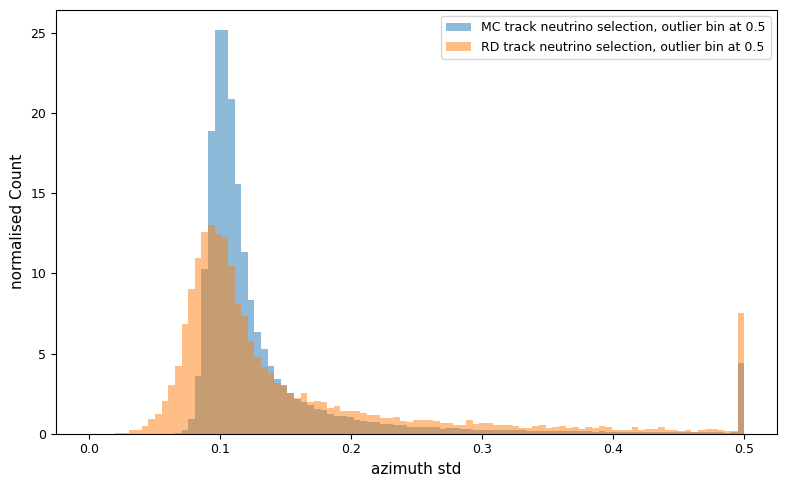

In [53]:
bins=np.linspace(0,0.5,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(np.clip(1/np.sqrt(azimuth_MC['azimuth_kappa'][azimuth_MC['event_no'].isin(pure_track_selection_MC)]),0,0.5),density=True,label='MC track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5,weights=azimuth_MC['osc_weight'][azimuth_MC['event_no'].isin(pure_track_selection_MC)])
axs.hist(np.clip(1/np.sqrt(azimuth_RD['azimuth_kappa'][azimuth_RD['event_no'].isin(pure_track_selection_RD)]),0,0.5),density=True,label='RD track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5)

axs.set_xlabel('azimuth std')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper right')

fig.tight_layout()

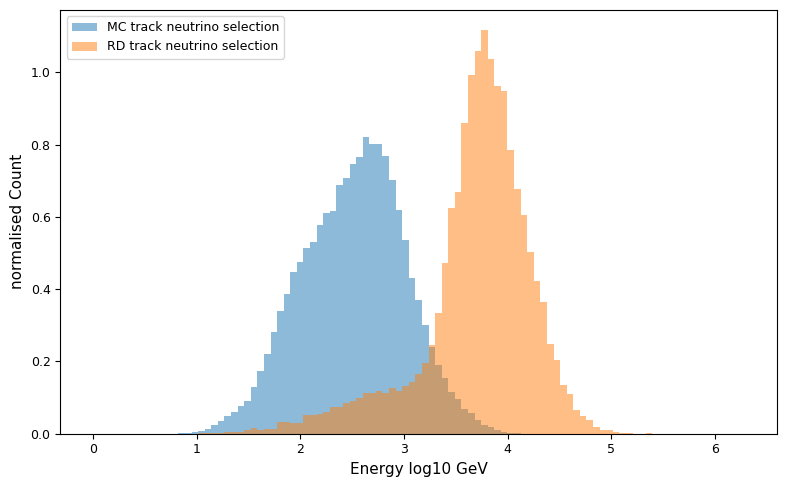

In [54]:
bins=np.linspace(0,np.pi*2,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(np.log10(energy_MC['energy_pred'][energy_MC['event_no'].isin(pure_track_selection_MC)]),density=True,label='MC track neutrino selection',bins=bins,alpha=0.5,weights=energy_MC['osc_weight'][energy_MC['event_no'].isin(pure_track_selection_MC)])
axs.hist(np.log10(energy_RD['energy_pred'][energy_RD['event_no'].isin(pure_track_selection_RD)]),density=True,label='RD track neutrino selection',bins=bins,alpha=0.5)

axs.set_xlabel('Energy log10 GeV')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()

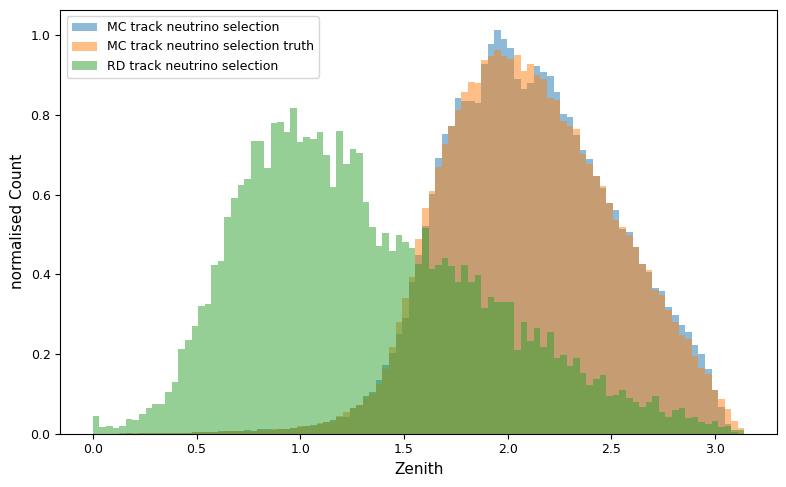

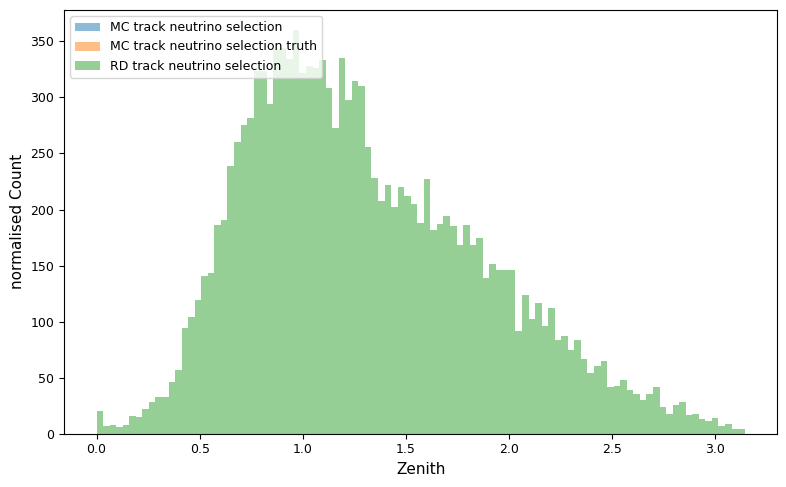

In [55]:
bins=np.linspace(0,np.pi,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(zenith_MC['zenith_pred'][zenith_MC['event_no'].isin(pure_track_selection_MC)],density=True,label='MC track neutrino selection',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_track_selection_MC)])
axs.hist(zenith_MC['zenith'][zenith_MC['event_no'].isin(pure_track_selection_MC)],density=True,label='MC track neutrino selection truth',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_track_selection_MC)])
axs.hist(zenith_RD['zenith_pred'][zenith_RD['event_no'].isin(pure_track_selection_RD)],density=True,label='RD track neutrino selection',bins=bins,alpha=0.5)

axs.set_xlabel('Zenith')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()


bins=np.linspace(0,np.pi,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(zenith_MC['zenith_pred'][zenith_MC['event_no'].isin(pure_track_selection_MC)],density=False,label='MC track neutrino selection',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_track_selection_MC)])
axs.hist(zenith_MC['zenith'][zenith_MC['event_no'].isin(pure_track_selection_MC)],density=False,label='MC track neutrino selection truth',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_track_selection_MC)])
axs.hist(zenith_RD['zenith_pred'][zenith_RD['event_no'].isin(pure_track_selection_RD)],density=False,label='RD track neutrino selection',bins=bins,alpha=0.5)

axs.set_xlabel('Zenith')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()

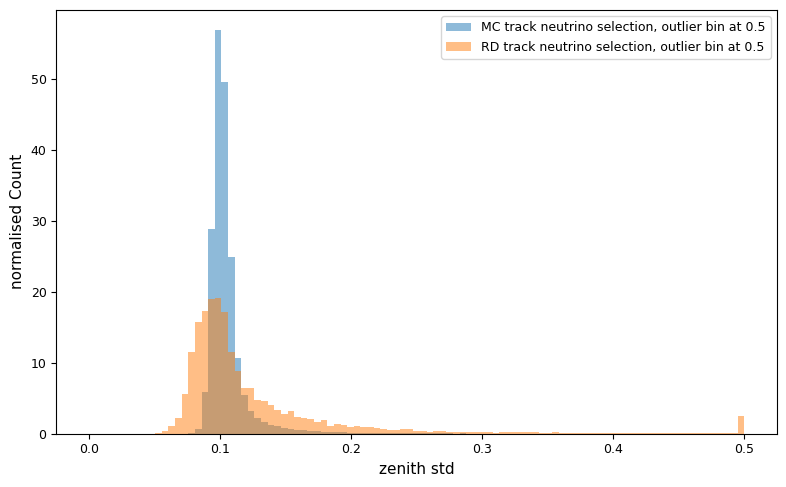

In [56]:
bins=np.linspace(0,0.5,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(np.clip(1/np.sqrt(zenith_MC['zenith_kappa'][zenith_MC['event_no'].isin(pure_track_selection_MC)]),0,0.5),density=True,label='MC track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_track_selection_MC)])
axs.hist(np.clip(1/np.sqrt(zenith_RD['zenith_kappa'][zenith_RD['event_no'].isin(pure_track_selection_RD)]),0,0.5),density=True,label='RD track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5)

axs.set_xlabel('zenith std')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper right')

fig.tight_layout()

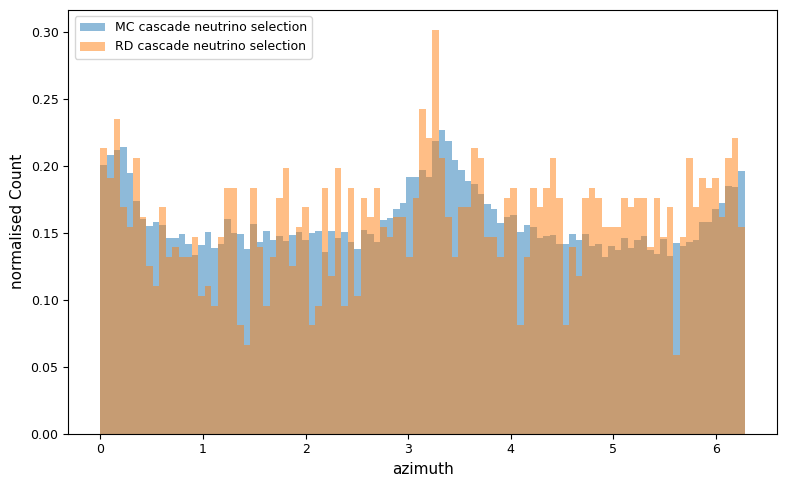

In [57]:
bins=np.linspace(0,np.pi*2,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(azimuth_MC['azimuth_pred'][azimuth_MC['event_no'].isin(pure_cascade_selection_MC)],density=True,label='MC cascade neutrino selection',bins=bins,alpha=0.5,weights=azimuth_MC['osc_weight'][azimuth_MC['event_no'].isin(pure_cascade_selection_MC)])
axs.hist(azimuth_RD['azimuth_pred'][azimuth_RD['event_no'].isin(pure_cascade_selection_RD)],density=True,label='RD cascade neutrino selection',bins=bins,alpha=0.5)

axs.set_xlabel('azimuth')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()

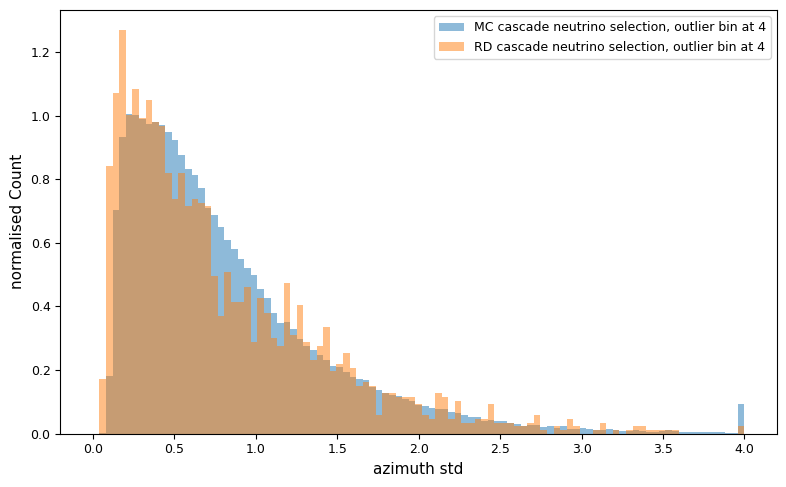

In [58]:
bins=np.linspace(0,4,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(np.clip(1/np.sqrt(azimuth_MC['azimuth_kappa'][azimuth_MC['event_no'].isin(pure_cascade_selection_MC)]),0,4),density=True,label='MC cascade neutrino selection, outlier bin at 4',bins=bins,alpha=0.5,weights=azimuth_MC['osc_weight'][azimuth_MC['event_no'].isin(pure_cascade_selection_MC)])
axs.hist(np.clip(1/np.sqrt(azimuth_RD['azimuth_kappa'][azimuth_RD['event_no'].isin(pure_cascade_selection_RD)]),0,4),density=True,label='RD cascade neutrino selection, outlier bin at 4',bins=bins,alpha=0.5)

axs.set_xlabel('azimuth std')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper right')

fig.tight_layout()

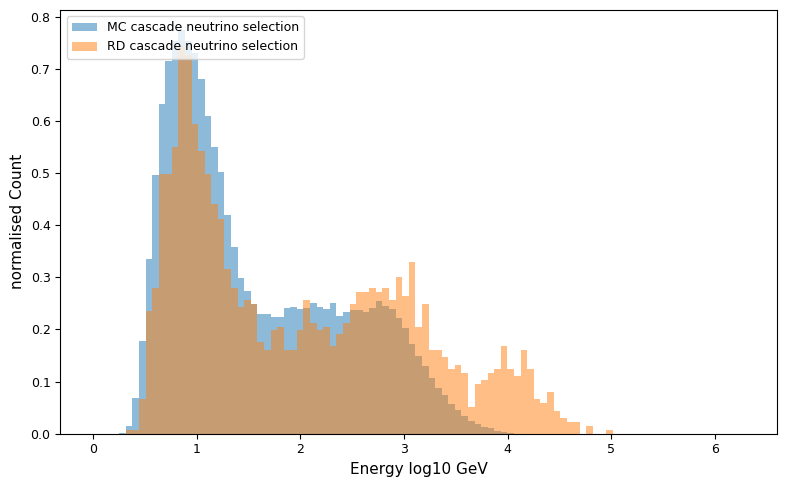

In [59]:
bins=np.linspace(0,np.pi*2,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(np.log10(energy_MC['energy_pred'][energy_MC['event_no'].isin(pure_cascade_selection_MC)]),density=True,label='MC cascade neutrino selection',bins=bins,alpha=0.5,weights=energy_MC['osc_weight'][energy_MC['event_no'].isin(pure_cascade_selection_MC)])
axs.hist(np.log10(energy_RD['energy_pred'][energy_RD['event_no'].isin(pure_cascade_selection_RD)]),density=True,label='RD cascade neutrino selection',bins=bins,alpha=0.5)

axs.set_xlabel('Energy log10 GeV')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()

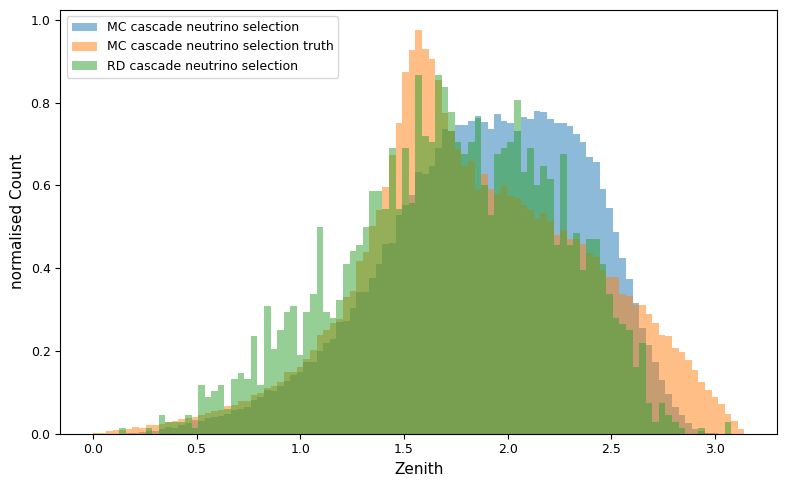

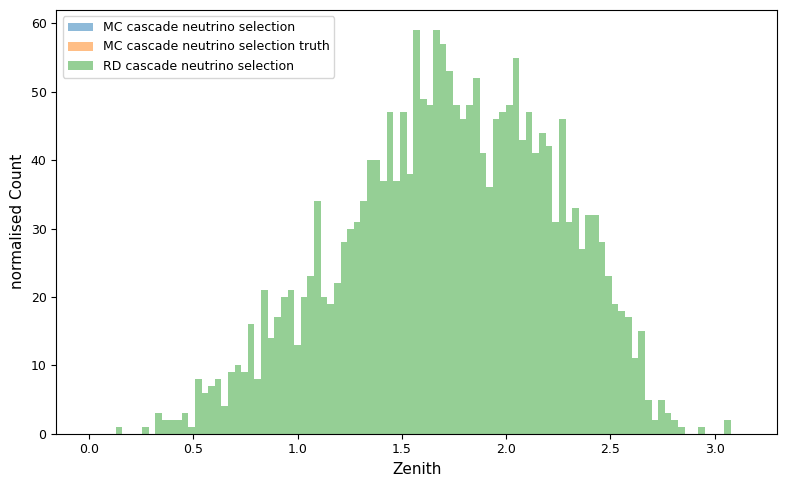

In [60]:
bins=np.linspace(0,np.pi,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(zenith_MC['zenith_pred'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)],density=True,label='MC cascade neutrino selection',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)])
axs.hist(zenith_MC['zenith'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)],density=True,label='MC cascade neutrino selection truth',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)])
axs.hist(zenith_RD['zenith_pred'][zenith_RD['event_no'].isin(pure_cascade_selection_RD)],density=True,label='RD cascade neutrino selection',bins=bins,alpha=0.5)

axs.set_xlabel('Zenith')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()


bins=np.linspace(0,np.pi,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(zenith_MC['zenith_pred'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)],density=False,label='MC cascade neutrino selection',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)])
axs.hist(zenith_MC['zenith'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)],density=False,label='MC cascade neutrino selection truth',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)])
axs.hist(zenith_RD['zenith_pred'][zenith_RD['event_no'].isin(pure_cascade_selection_RD)],density=False,label='RD cascade neutrino selection',bins=bins,alpha=0.5)

axs.set_xlabel('Zenith')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()

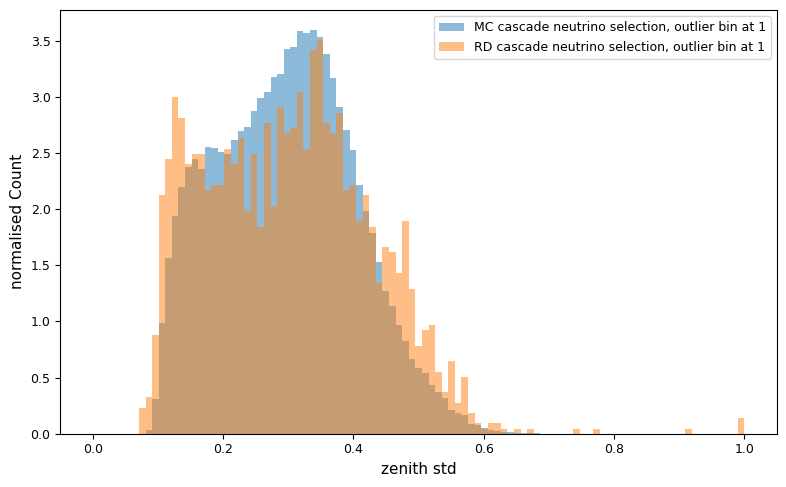

In [61]:
bins=np.linspace(0,1,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(np.clip(1/np.sqrt(zenith_MC['zenith_kappa'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)]),0,1),density=True,label='MC cascade neutrino selection, outlier bin at 1',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)])
axs.hist(np.clip(1/np.sqrt(zenith_RD['zenith_kappa'][zenith_RD['event_no'].isin(pure_cascade_selection_RD)]),0,1),density=True,label='RD cascade neutrino selection, outlier bin at 1',bins=bins,alpha=0.5)

axs.set_xlabel('zenith std')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper right')

fig.tight_layout()

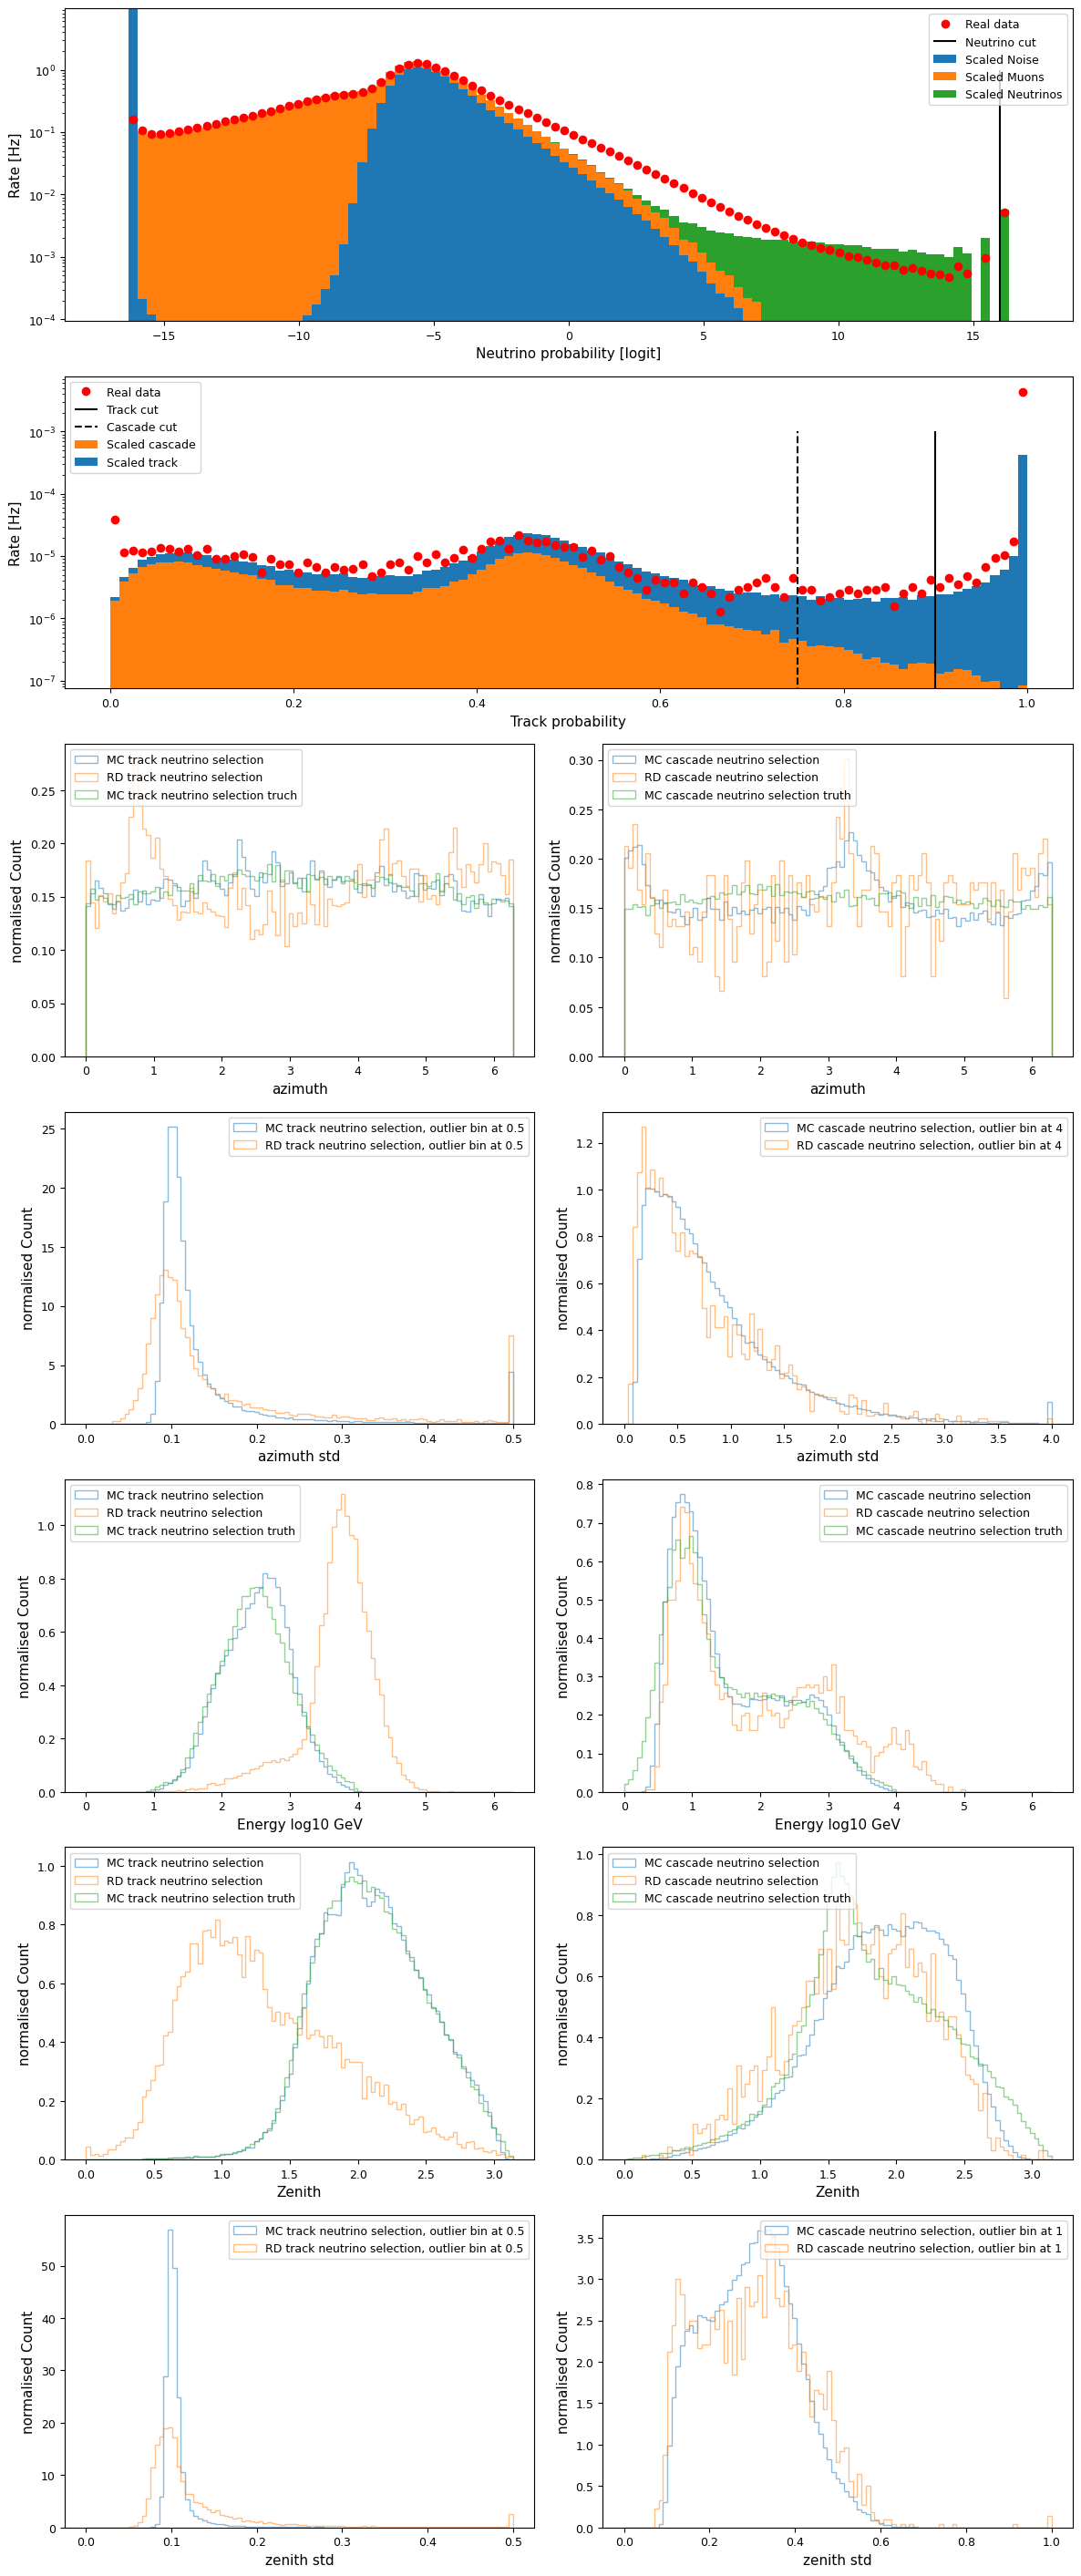

: 

In [67]:
with_MC_truth = True


bins_to_use = np.linspace(-17,17,101)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2
bin_width = bins_to_use[1]-bins_to_use[0]

fig = plt.figure(figsize=(12,32))
ax1 = plt.subplot2grid(shape=(8,2), loc=(0,0), colspan=2, fig=fig)
ax1.bar(bins_middle,counts_noise_plot,width=bin_width,label='Scaled Noise')
ax1.bar(bins_middle,counts_muon_plot,width=bin_width,bottom=counts_noise_plot,label='Scaled Muons')
ax1.bar(bins_middle,counts_neutrino_plot,width=bin_width,bottom=counts_noise_plot+counts_muon_plot,label='Scaled Neutrinos')
ax1.plot(bins_middle,counts_RD,'o',label='Real data',color='red')
ax1.vlines(Neutrino_cut,0,1,color='black',label='Neutrino cut')
ax1.set_xlabel('Neutrino probability [logit]')
#ax1.set_ylim(bottom=1000)
ax1.set_ylabel('Rate [Hz]')
ax1.set_yscale('log')
ax1.legend(loc='upper right')


bins_to_use = np.linspace(0,1,101)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2
bin_width = bins_to_use[1]-bins_to_use[0]
ax2 = plt.subplot2grid((8,2), (1,0), colspan=2)
ax2.bar(bins_middle,counts_cascade_plot,width=bin_width,label='Scaled cascade',color='C1')
ax2.bar(bins_middle,counts_track_plot,width=bin_width,bottom=counts_cascade_plot,label='Scaled track',color='C0')
ax2.plot(bins_middle,counts_RD_multiclass,'o',label='Real data',color='red')
ax2.vlines(track_cut,0,10**-3,color='black',label='Track cut')
ax2.vlines(cascade_cut,0,10**-3,color='black',linestyle='dashed',label='Cascade cut')
ax2.set_xlabel('Track probability')
ax2.set_ylabel('Rate [Hz]')
ax2.set_yscale('log')
ax2.legend(loc='upper left')

bins=np.linspace(0,np.pi*2,100)
ax3 = plt.subplot2grid((8,2), (2,0), colspan=1)
ax3.hist(azimuth_MC['azimuth_pred'][azimuth_MC['event_no'].isin(pure_track_selection_MC)], histtype='step',density=True,label='MC track neutrino selection',bins=bins,alpha=0.5,weights=azimuth_MC['osc_weight'][azimuth_MC['event_no'].isin(pure_track_selection_MC)])
ax3.hist(azimuth_RD['azimuth_pred'][azimuth_RD['event_no'].isin(pure_track_selection_RD)], histtype='step',density=True,label='RD track neutrino selection',bins=bins,alpha=0.5)
if with_MC_truth:
    ax3.hist(azimuth_MC['azimuth'][azimuth_MC['event_no'].isin(pure_track_selection_MC)], histtype='step',density=True,label='MC track neutrino selection truch',bins=bins,alpha=0.5,weights=azimuth_MC['osc_weight'][azimuth_MC['event_no'].isin(pure_track_selection_MC)])
ax3.set_xlabel('azimuth')
ax3.set_ylabel('normalised Count')
ax3.legend(loc='upper left')

ax4 = plt.subplot2grid((8,2), (2,1), colspan=1)
bins=np.linspace(0,np.pi*2,100)
ax4.hist(azimuth_MC['azimuth_pred'][azimuth_MC['event_no'].isin(pure_cascade_selection_MC)], histtype='step',density=True,label='MC cascade neutrino selection',bins=bins,alpha=0.5,weights=azimuth_MC['osc_weight'][azimuth_MC['event_no'].isin(pure_cascade_selection_MC)])
ax4.hist(azimuth_RD['azimuth_pred'][azimuth_RD['event_no'].isin(pure_cascade_selection_RD)], histtype='step',density=True,label='RD cascade neutrino selection',bins=bins,alpha=0.5)
if with_MC_truth:
    ax4.hist(azimuth_MC['azimuth'][azimuth_MC['event_no'].isin(pure_cascade_selection_MC)], histtype='step',density=True,label='MC cascade neutrino selection truth',bins=bins,alpha=0.5,weights=azimuth_MC['osc_weight'][azimuth_MC['event_no'].isin(pure_cascade_selection_MC)])
ax4.set_xlabel('azimuth')
ax4.set_ylabel('normalised Count')
ax4.legend(loc='upper left')

ax5 = plt.subplot2grid((8,2), (3,0), colspan=1)
bins=np.linspace(0,0.5,100)
ax5.hist(np.clip(1/np.sqrt(azimuth_MC['azimuth_kappa'][azimuth_MC['event_no'].isin(pure_track_selection_MC)]),0,0.5), histtype='step',density=True,label='MC track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5,weights=azimuth_MC['osc_weight'][azimuth_MC['event_no'].isin(pure_track_selection_MC)])
ax5.hist(np.clip(1/np.sqrt(azimuth_RD['azimuth_kappa'][azimuth_RD['event_no'].isin(pure_track_selection_RD)]),0,0.5), histtype='step',density=True,label='RD track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5)
ax5.set_xlabel('azimuth std')
ax5.set_ylabel('normalised Count')
ax5.legend(loc='upper right')


ax6 = plt.subplot2grid((8,2), (3,1), colspan=1)
bins=np.linspace(0,4,100)
ax6.hist(np.clip(1/np.sqrt(azimuth_MC['azimuth_kappa'][azimuth_MC['event_no'].isin(pure_cascade_selection_MC)]),0,4), histtype='step',density=True,label='MC cascade neutrino selection, outlier bin at 4',bins=bins,alpha=0.5,weights=azimuth_MC['osc_weight'][azimuth_MC['event_no'].isin(pure_cascade_selection_MC)])
ax6.hist(np.clip(1/np.sqrt(azimuth_RD['azimuth_kappa'][azimuth_RD['event_no'].isin(pure_cascade_selection_RD)]),0,4), histtype='step',density=True,label='RD cascade neutrino selection, outlier bin at 4',bins=bins,alpha=0.5)
ax6.set_xlabel('azimuth std')
ax6.set_ylabel('normalised Count')
ax6.legend(loc='upper right')

ax7 = plt.subplot2grid((8,2), (4,0), colspan=1)
bins=np.linspace(0,np.pi*2,100)
ax7.hist(np.log10(energy_MC['energy_pred'][energy_MC['event_no'].isin(pure_track_selection_MC)]), histtype='step',density=True,label='MC track neutrino selection',bins=bins,alpha=0.5,weights=energy_MC['osc_weight'][energy_MC['event_no'].isin(pure_track_selection_MC)])
ax7.hist(np.log10(energy_RD['energy_pred'][energy_RD['event_no'].isin(pure_track_selection_RD)]), histtype='step',density=True,label='RD track neutrino selection',bins=bins,alpha=0.5)
if with_MC_truth:
    ax7.hist(np.log10(energy_MC['energy'][energy_MC['event_no'].isin(pure_track_selection_MC)]), histtype='step',density=True,label='MC track neutrino selection truth',bins=bins,alpha=0.5,weights=energy_MC['osc_weight'][energy_MC['event_no'].isin(pure_track_selection_MC)])

ax7.set_xlabel('Energy log10 GeV')
ax7.set_ylabel('normalised Count')
ax7.legend(loc='upper left')


ax8 = plt.subplot2grid((8,2), (4,1), colspan=1)
bins=np.linspace(0,np.pi*2,100)
ax8.hist(np.log10(energy_MC['energy_pred'][energy_MC['event_no'].isin(pure_cascade_selection_MC)]), histtype='step',density=True,label='MC cascade neutrino selection',bins=bins,alpha=0.5,weights=energy_MC['osc_weight'][energy_MC['event_no'].isin(pure_cascade_selection_MC)])
ax8.hist(np.log10(energy_RD['energy_pred'][energy_RD['event_no'].isin(pure_cascade_selection_RD)]), histtype='step',density=True,label='RD cascade neutrino selection',bins=bins,alpha=0.5)
if with_MC_truth:
    ax8.hist(np.log10(energy_MC['energy'][energy_MC['event_no'].isin(pure_cascade_selection_MC)]), histtype='step',density=True,label='MC cascade neutrino selection truth',bins=bins,alpha=0.5,weights=energy_MC['osc_weight'][energy_MC['event_no'].isin(pure_cascade_selection_MC)])
ax8.set_xlabel('Energy log10 GeV')
ax8.set_ylabel('normalised Count')
ax8.legend(loc='upper right')



ax9 = plt.subplot2grid((8,2), (5,0), colspan=1)
bins=np.linspace(0,np.pi,100)
ax9.hist(zenith_MC['zenith_pred'][zenith_MC['event_no'].isin(pure_track_selection_MC)], histtype='step',density=True,label='MC track neutrino selection',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_track_selection_MC)])
ax9.hist(zenith_RD['zenith_pred'][zenith_RD['event_no'].isin(pure_track_selection_RD)], histtype='step',density=True,label='RD track neutrino selection',bins=bins,alpha=0.5)
if with_MC_truth:
    ax9.hist(zenith_MC['zenith'][zenith_MC['event_no'].isin(pure_track_selection_MC)], histtype='step',density=True,label='MC track neutrino selection truth',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_track_selection_MC)])
ax9.set_xlabel('Zenith')
ax9.set_ylabel('normalised Count')
ax9.legend(loc='upper left')



ax10 = plt.subplot2grid((8,2), (5,1), colspan=1)
bins=np.linspace(0,np.pi,100)
ax10.hist(zenith_MC['zenith_pred'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)], histtype='step',density=True,label='MC cascade neutrino selection',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)])
ax10.hist(zenith_RD['zenith_pred'][zenith_RD['event_no'].isin(pure_cascade_selection_RD)], histtype='step',density=True,label='RD cascade neutrino selection',bins=bins,alpha=0.5)
if with_MC_truth:
    ax10.hist(zenith_MC['zenith'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)], histtype='step',density=True,label='MC cascade neutrino selection truth',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)])
ax10.set_xlabel('Zenith')
ax10.set_ylabel('normalised Count')
ax10.legend(loc='upper left')


ax11 = plt.subplot2grid((8,2), (6,0), colspan=1)
bins=np.linspace(0,0.5,100)
ax11.hist(np.clip(1/np.sqrt(zenith_MC['zenith_kappa'][zenith_MC['event_no'].isin(pure_track_selection_MC)]),0,0.5), histtype='step',density=True,label='MC track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_track_selection_MC)])
ax11.hist(np.clip(1/np.sqrt(zenith_RD['zenith_kappa'][zenith_RD['event_no'].isin(pure_track_selection_RD)]),0,0.5), histtype='step',density=True,label='RD track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5)
ax11.set_xlabel('zenith std')
ax11.set_ylabel('normalised Count')
ax11.legend(loc='upper right')


ax12 = plt.subplot2grid((8,2), (6,1), colspan=1)
bins=np.linspace(0,1,100)
ax12.hist(np.clip(1/np.sqrt(zenith_MC['zenith_kappa'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)]),0,1), histtype='step',density=True,label='MC cascade neutrino selection, outlier bin at 1',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)])
ax12.hist(np.clip(1/np.sqrt(zenith_RD['zenith_kappa'][zenith_RD['event_no'].isin(pure_cascade_selection_RD)]),0,1), histtype='step',density=True,label='RD cascade neutrino selection, outlier bin at 1',bins=bins,alpha=0.5)
ax12.set_xlabel('zenith std')
ax12.set_ylabel('normalised Count')
ax12.legend(loc='upper right')


fig.tight_layout()

In [ ]:
all_info_cascade_dir_MC = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/Troels_cascade_events/Troels_cascade_eventsclean_cascade_events_MC_final.csv"
all_info_cascade_dir_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/Troels_cascade_events/Troels_cascade_eventsclean_cascade_events_RD_final.csv"

all_info_cascade_MC = pd.read_csv(all_info_cascade_dir_MC,usecols=['event_no','N_pulses','N_doms','N_string','energy_pred'])
all_info_cascade_RD = pd.read_csv(all_info_cascade_dir_RD,usecols=['event_no','N_pulses','N_doms','N_string','energy_pred'])

In [ ]:
print(all_info_cascade_MC.tail(2))
print(energy_MC[energy_MC['event_no']==68471299])
print(track_cascade_MC[track_cascade_MC['event_no']==68471299])

print(all_info_cascade_RD.tail(2))
print(energy_RD[energy_RD['event_no']==99903207])
print(track_cascade_RD[track_cascade_RD['event_no']==99903207])

           event_no  energy_pred  N_pulses  N_string  N_doms
3622590  68471299.0  1136.092651        89        28      58
3622591  68471345.0   764.966431       171        45     113
         Unnamed: 0  energy_pred       energy    event_no    osc_weight
4585520     1379625  1136.092651  1417.981689  68471299.0  1.866490e-11
         Unnamed: 0  track_mu_pred  track_mu    event_no    osc_weight
4585520     1379625       0.076048       0.0  68471299.0  1.866490e-11
          event_no  energy_pred  N_pulses  N_string  N_doms
245047  99903207.0    17.595076        39        30      34
245048  99903429.0    23.382580        48        30      40
          Unnamed: 0  energy_pred    event_no    osc_weight
61738646    61738646    17.595076  99903207.0  3.168874e-07
          Unnamed: 0  track_mu_pred    event_no    osc_weight
61738646    61738646        0.45781  99903207.0  3.168874e-07


In [ ]:
from standard_plotting import set_size
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
}

plt.rcParams.update(tex_fonts)

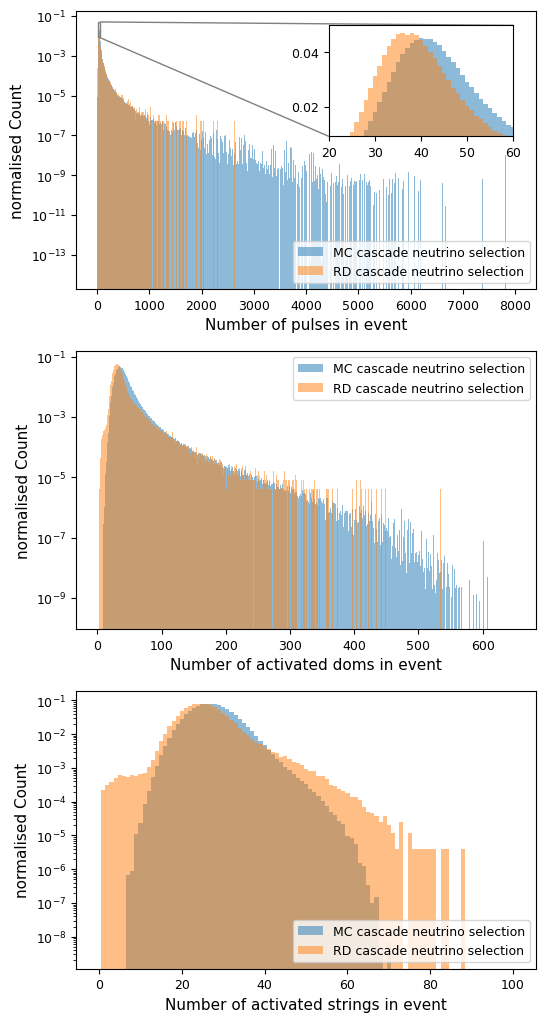

In [ ]:

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, axs = plt.subplots(3,1,figsize=set_size('thesis',subplots=(3,1)))
bins=np.linspace(0,8000,1000)+0.5
axs[0].hist(all_info_cascade_MC['N_pulses'],density=True,label='MC cascade neutrino selection',bins=bins,alpha=0.5,weights=np.array(zenith_MC['osc_weight'][zenith_MC['event_no'].isin(all_info_cascade_MC.event_no.to_list())]))
axs[0].hist(all_info_cascade_RD['N_pulses'],density=True,label='RD cascade neutrino selection',bins=bins,alpha=0.5)
axs[0].set_xlabel('Number of pulses in event')
axs[0].set_ylabel('normalised Count')
axs[0].set_yscale('log')
axs[0].legend(loc='lower right')

bins=np.linspace(24,60,37)+0.5
#axins = zoomed_inset_axes(axs[0], zoom=4, loc='lower right',bbox_to_anchor=(500,850)) # zoom = 6
axins = axs[0].inset_axes([0.55, 0.55, 0.4, 0.4]) 
axins.hist(all_info_cascade_MC['N_pulses'],density=True,label='MC cascade neutrino selection',bins=bins,alpha=0.5,weights=np.array(zenith_MC['osc_weight'][zenith_MC['event_no'].isin(all_info_cascade_MC.event_no.to_list())]))
axins.hist(all_info_cascade_RD['N_pulses'],density=True,label='RD cascade neutrino selection',bins=bins,alpha=0.5)
axins.set_xlim(20,60)
axins.set_ylim(0.009,0.05)
#axins.set_yscale('log')
# plt.xticks(visible=False)
# plt.yticks(visible=False)
mark_inset(axs[0], axins, loc1=1, loc2=3, fc="none", ec="0.5")

bins=np.linspace(-1,650,652)+0.5
axs[1].hist(all_info_cascade_MC['N_doms'],density=True,label='MC cascade neutrino selection',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(all_info_cascade_MC.event_no.to_list())])
axs[1].hist(all_info_cascade_RD['N_doms'],density=True,label='RD cascade neutrino selection',bins=bins,alpha=0.5)
axs[1].set_xlabel('Number of activated doms in event')
axs[1].set_ylabel('normalised Count')
axs[1].set_yscale('log')
axs[1].legend(loc='upper right')

bins=np.linspace(-1,100,102)+0.5
axs[2].hist(all_info_cascade_MC['N_string'],density=True,label='MC cascade neutrino selection',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(all_info_cascade_MC.event_no.to_list())])
axs[2].hist(all_info_cascade_RD['N_string'],density=True,label='RD cascade neutrino selection',bins=bins,alpha=0.5)
axs[2].set_xlabel('Number of activated strings in event')
axs[2].set_ylabel('normalised Count')
axs[2].set_yscale('log')
axs[2].legend(loc='lower right')

fig.tight_layout()

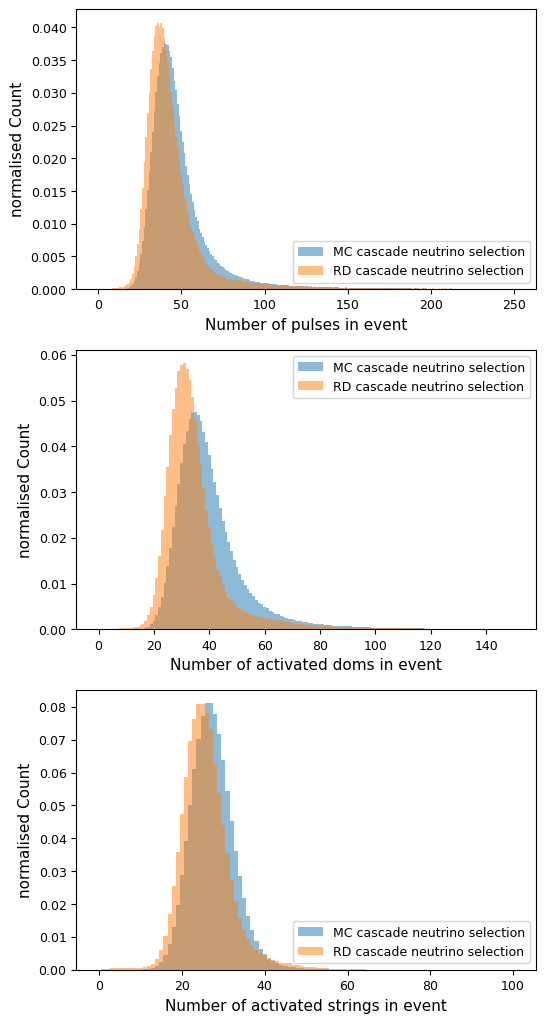

In [ ]:
fig, axs = plt.subplots(3,1,figsize=set_size('thesis',subplots=(3,1)))
bins=np.linspace(-1,250,252)+0.5
axs[0].hist(all_info_cascade_MC['N_pulses'],density=True,label='MC cascade neutrino selection',bins=bins,alpha=0.5,weights=np.array(zenith_MC['osc_weight'][zenith_MC['event_no'].isin(all_info_cascade_MC.event_no.to_list())]))
axs[0].hist(all_info_cascade_RD['N_pulses'],density=True,label='RD cascade neutrino selection',bins=bins,alpha=0.5)
axs[0].set_xlabel('Number of pulses in event')
axs[0].set_ylabel('normalised Count')
#axs[0].set_yscale('log')
axs[0].legend(loc='lower right')


bins=np.linspace(-1,150,152)+0.5
axs[1].hist(all_info_cascade_MC['N_doms'],density=True,label='MC cascade neutrino selection',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(all_info_cascade_MC.event_no.to_list())])
axs[1].hist(all_info_cascade_RD['N_doms'],density=True,label='RD cascade neutrino selection',bins=bins,alpha=0.5)
axs[1].set_xlabel('Number of activated doms in event')
axs[1].set_ylabel('normalised Count')
#axs[1].set_yscale('log')
axs[1].legend(loc='upper right')

bins=np.linspace(-1,100,102)+0.5
axs[2].hist(all_info_cascade_MC['N_string'],density=True,label='MC cascade neutrino selection',bins=bins,alpha=0.5,weights=zenith_MC['osc_weight'][zenith_MC['event_no'].isin(all_info_cascade_MC.event_no.to_list())])
axs[2].hist(all_info_cascade_RD['N_string'],density=True,label='RD cascade neutrino selection',bins=bins,alpha=0.5)
axs[2].set_xlabel('Number of activated strings in event')
axs[2].set_ylabel('normalised Count')
#axs[2].set_yscale('log')
axs[2].legend(loc='lower right')

fig.tight_layout()

In [ ]:
print(all_info_cascade_RD.groupby('N_pulses').nunique())

          event_no  energy_pred  N_string  N_doms
N_pulses                                         
5                3            3         2       2
6                5            5         3       3
7               21           21         3       4
8               17           17         5       4
9               33           33         6       6
...            ...          ...       ...     ...
3315             1            1         1       1
3366             1            1         1       1
3694             1            1         1       1
5503             1            1         1       1
6215             1            1         1       1

[813 rows x 4 columns]


In [ ]:
print(np.max(all_info_cascade_RD['N_pulses']))
print(np.max(all_info_cascade_MC['N_pulses']))

print(np.max(all_info_cascade_RD['N_doms']))
print(np.max(all_info_cascade_MC['N_doms']))

print(np.max(all_info_cascade_RD['N_string']))
print(np.max(all_info_cascade_MC['N_string']))

6215
7815
566
607
88
70


In [ ]:
print(len(all_info_cascade_RD[all_info_cascade_RD['N_pulses']>400]))
print(len(all_info_cascade_MC[all_info_cascade_MC['N_pulses']>400]))

668
34816
